# Spatially varying rate demo

Flamedisx has built-in support for sources with a fixed energy spectrum, but spatially varying rate, specified by a histogram. This notebook demonstrates how to make use of this.

(Flamedisx also supports sources with spatio-temporally varying energy spectra; see the VariableEnergySpectrum and WIMPEnergySpectrum for examples.)

In [1]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
%run _if_on_colab_setup_flamedisx.ipynb

Flamedisx is installed :-)


In [2]:
import matplotlib.pyplot as plt
from multihist import Histdd, Hist1d
import numpy as np

import flamedisx as fd

Below is a placeholder for a simulator that produces positions. Instead of this, you might e.g. load in simulated radiogenic neutron events from a GEANT MC.

This placeholder distributes events uniformly in an annulus. If you actually want such a simple distribution, you could directly create the spatial rate histogram without simulation.

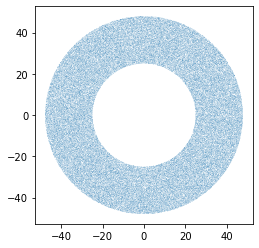

In [3]:
r_max = fd.EnergySpectrum.fv_radius
z_max = fd.EnergySpectrum.fv_low
q_max = 2 * np.pi
r_cut = 25

def simulate_ring(n_trials=100_000):
    r, q, z = np.random.rand(3, 2 * n_trials)
    r = r**0.5 * r_max
    q *= q_max
    z *= z_max
    d = np.stack([r, q, z])
    # Remove events below r_cut
    return d[:, r > r_cut]

d_sim = simulate_ring()
x = d_sim[0] * np.cos(d_sim[1])
y = d_sim[0] * np.sin(d_sim[1])
plt.scatter(x, y, marker='.', s=0.3, edgecolors='none')
plt.gca().set_aspect('equal')

We now need to histogram the events for flamedisx.

Flamedisx supports either Cartesian $(x, y, z)$ or cylindrical $(r, \theta, z)$ histograms. You are free to use non-uniform binning in both cases.

Clearly, cylindrical coordinates are suitable for this problem. If you bin uniformly in $r$, bins at high radii will be larger -- recall that the volume element in cylindrical coordinates is $r dr d\theta dz$. Uniform $r$ binning is therefore a bad idea: it would mean inner bins get very few events, and outer bins would be huge and fail to capture local variations near the wall. It is usually better to bin uniformly in $r^2$, so the physical bin volumes are all the same.

Moreover, you'll want to tune your binning to your simulation size. In this case, we have a big simulation, and no need to split it up over $z$ and $\theta$, so we can get away with quite a few radial bins.

However, let's **ignore all this advice and choose a bad binning**, uniform in r and with only 10 bins --  just to show you what happens.

In [4]:
# BAD IDEA: coarse uniform-r binning
# DO NOT USE!!
r_edges = np.linspace(0, r_max, 10 + 1)

# RECOMMENDED INSTEAD: finer & uniform volume binning
# r_edges = np.linspace(0, r_max**2, 50 + 1)**0.5

# We can just use 1 bin in theta and z in this example.
q_edges = np.linspace(0, q_max, 1 + 1)
z_edges = np.linspace(z_max, 0, 1 + 1)

mh = Histdd(
    *d_sim,
    dimensions=(('r', r_edges), ('theta', q_edges), ('z', z_edges)))

You now have a histogram in units of [simulated events / bin]. Let's first convert this to the physical (probablility) density, i.e. to [fraction of events / volume]:

In [5]:
class ERSpatial(fd.SpatialRateERSource):
    spatial_hist = mh
    
ll = fd.LogLikelihood(
    sources=dict(er_annulus=ERSpatial,
                 er_homogeneous=fd.ERSource))

Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]


In [6]:
for sname, s in ll.sources.items():
    print(f"Source {sname}, "
          f"before efficiencies {ll.sources[sname].mu_before_efficiencies():.1f} events, "
          f"after efficiencies {ll.mu(source_name=sname):.1f} events.")

Source er_annulus, before efficiencies 1000.0 events, after efficiencies 846.8 events.
Source er_homogeneous, before efficiencies 1000.0 events, after efficiencies 846.2 events.


As you can see, the expected number of events before efficiencies is exactly the same for the annulus-source as for a homogeneous source with the same energy spectrum.

Since we have defined no radially varying efficiencies in this example, this also holds after efficiencies, up to small statistical errors. The mu after efficiencies is estimated by simulation; try setting n_trials = int(1e6) in the likelihood above, and see the difference decrease.

Let's simulate some new events with flamedisx, to check flamedisx has understood our radial distribution:

In [7]:
source = ll.sources['er_annulus']
d_new = source.simulate(1_000_000)

Text(0, 0.5, 'Fraction of events / $dr^2$ [$\\mathrm{cm}^{-2}$]')

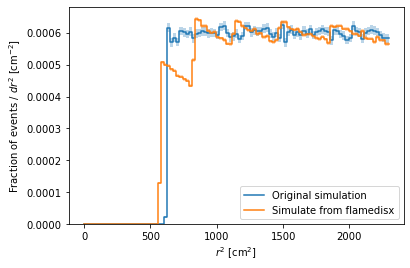

In [8]:
for r, label in ((d_sim[0], 'Original simulation'), 
                 (d_new['r'], 'Simulate from flamedisx')):
    h = Hist1d(r**2, bins=np.linspace(0, r_max**2, 100))
    h.plot(scale_histogram_by=1/(h.n * h.bin_volumes()),
           errors=True, error_style='band', label=label)
plt.xlabel("$r^2$ [$\mathrm{cm}^2$]")
plt.ylim(0, None)
plt.legend(loc='lower right')
plt.ylabel("Fraction of events / $dr^2$ [$\mathrm{cm}^{-2}$]")

As you can see, flamedisx's distribution is not completely wrong, but it is distorted by artifacts due to the poor choice of binning:
  * Flamedisx draws positions uniformly in each bin. In this coarse r-binning, that's a poor approximation; events are more likely to be at high radii in a each bin.
  * Since the inner ring's edge is not exactly at an r bin edge, flamedisx shows an intermediate step rather than a sharp cutoff.

If you use the smarter choice of binning (currently commented out) and re-run the notebook, these effects mostly disappear. If you set r_cut = 0, the first effect would still be significant at low $r$. If the distribution around $r=0$ is relevant, it may currently be better to use Cartesian binning -- even for a radially symmetric problem.

So far we've only probed flamedisx's simulation.

Let's compare the differential rates for homogeneous and spatially varying sources, to check that flamedisx will compute correct likelihoods as well.

In [9]:
d = ll.sources['er_homogeneous'].simulate(200)
ll.set_data(d)
for sname, s in ll.sources.items():
    d[f'dr_{sname}'] = s.batched_differential_rate()

100%|██████████| 18/18 [00:01<00:00, 10.39it/s]


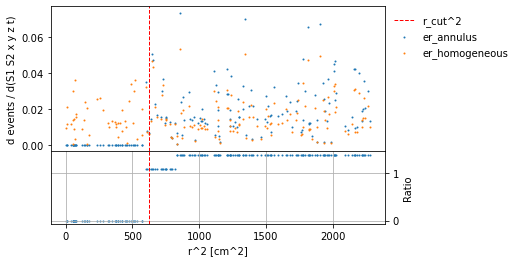

In [10]:
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw=dict(height_ratios=[2,1]))

plt.sca(axes[0])
for sname, s in ll.sources.items():
    plt.scatter(d['r']**2, d[f'dr_{sname}'], label=sname, s=1)

for ax in axes:
    ax.axvline(r_cut**2, color='r', label='r_cut^2',
               linestyle='--', linewidth=1)
    
plt.legend(loc='upper left', 
           bbox_to_anchor=(1,1),
           frameon=False)
plt.ylabel("d events / d(S1 S2 x y z t)")
    
plt.sca(axes[1])
plt.scatter(d['r']**2, d[f'dr_er_annulus'] / d['dr_er_homogeneous'], label=sname, s=1)

plt.xlabel("r^2 [cm^2]")
plt.ylabel("Ratio")
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')
plt.grid()


plt.subplots_adjust(hspace=0)
#axes[1].tick_params(left=False, right=True, labelleft=False, e)

Indeed, the differential rates of the annular source are equal to those of a uniform source, except for scaling by an r-dependent step function. The intermediate step is because r_cut is not exactly on a radial bin edge.

You can re-run the notebook with r_cut = 0, and see that the differential rates become equal -- up to small errors due to the binning, especially at low radius.